In [1]:
import sys
sys.path.append('..')
import numpy as np
import tqdm
import argparse
import pyDOE
from sklearn.gaussian_process.kernels import Matern

from robustGP.SURmodel import AdaptiveStrategy
from robustGP.test_functions import branin_2d
import robustGP.tools as tools
import robustGP.acquisition.acquisition as ac

In [2]:

def initialize_branin(initial_design=None):
    """
    Create new instance of AdaptiveStrategy of the Branin 2d function
    with LHS as initial design
    """
    NDIM = 2
    bounds = np.asarray([(0, 1)] * NDIM)
    if initial_design is None:
        initial_design = 5 * NDIM
    if isinstance(initial_design, int):
        initial_design = pyDOE.lhs(
            n=NDIM, samples=initial_design, criterion="maximin", iterations=50
        )
    branin = AdaptiveStrategy(bounds, branin_2d)
    branin.fit_gp(
        initial_design,
        branin.evaluate_function(initial_design),
        Matern(np.ones(NDIM)),
        n_restarts_optimizer=50,
    )
    branin.set_idxU([1], ndim=2)
    return branin


bounds = np.asarray([[0, 1], [0, 1]])
# For plots
x, y = np.linspace(0, 1, 50), np.linspace(0, 1, 50)
(XY, (xmg, ymg)) = tools.pairify((x, y))
xl, yl = np.linspace(0, 1, 500), np.linspace(0, 1, 500)
(XYl, (xmgl, ymgl)) = tools.pairify((xl, yl))
xs, ys = np.linspace(0, 1, 20), np.linspace(0, 1, 20)
(XYs, (xmgs, ymgs)) = tools.pairify((xs, ys))

xsmall, ysmall = np.linspace(0, 1, 4), np.linspace(0, 1, 4)
(XYsmall, (xmgsmall, ymgsmall)) = tools.pairify((xsmall, ysmall))


branin = initialize_branin(6)


def augmented_IMSE(arg, X, scenarios, integration_points, verbose=True):
    if callable(integration_points):
        int_points = integration_points()
    else:
        int_points = integration_points

    def function_(arg):
        m, sd = arg.predict(int_points, return_std=True)
        return sd**2

    return ac.augmented_design(arg, X, scenarios, function_, {}, verbose=verbose)


def augmented_IMSE_Delta(
    arg, X, scenarios, integration_points, alpha, beta=0, verbose=True
):
    if callable(integration_points):
        int_points = integration_points()
    else:
        int_points = integration_points

    def function_(arg):
        m, va = arg.predict_GPdelta(int_points, alpha=alpha, beta=beta)
        return va

    return ac.augmented_design(arg, X, scenarios, function_, {}, verbose=verbose)


def augmented_IVPC_Delta(
    arg, X, scenarios, integration_points, alpha, beta=0, verbose=True
):
    if callable(integration_points):
        int_points = integration_points()
    else:
        int_points = integration_points

    def function_(arg):
        m, va = arg.predict_GPdelta(int_points, alpha=alpha, beta=beta)
        s = np.sqrt(va)
        return ac.variance_probability_coverage((m, s), None, 0)

    return ac.augmented_design(arg, X, scenarios, function_, {}, verbose=verbose)


def save_at_each_iteration(filename, header=None):
    def decorator(function):
        def saving_function(XY, *args, **kwargs):
            print(filename)
            if header is not None:
                with open(filename, "w+") as fhandle:
                    to_write = f"#{header}\n"
                    print(f"-- {to_write}")
                    fhandle.write(to_write)
            for xy in tqdm.tqdm(XY):
                response = function(xy.reshape(-1, 2), *args, **kwargs)
                with open(filename, "a+") as fhandle:
                    to_write = np.atleast_2d(np.hstack([xy[0], xy[1], response]))
                    np.savetxt(fhandle, to_write, delimiter=",")
            return None

        return saving_function

    return decorator

import multiprocessing
def save_at_each_iteration_parallel(filename, header=None, nworkers=4):
    def decorator(function):
        pool = multiprocessing.Pool(processes=nworkers)
        def pooled_func(XY, *args, **kwargs):
            elt_func = lambda xy: function(xy.reshape(-1, 2), *args, **kwargs)
            result = pool.map(elt_func, XY)
            return result
        return pooled_func

    return decorator

In [3]:
integration_points = pyDOE.lhs(2, 50, criterion="maximin", iterations=50)
imse = branin.gp.predict(integration_points, return_std=True)[1]**2

@save_at_each_iteration("tmp/aIMSE.txt", header="aimse")
def function_aIMSE(XY):
    return augmented_IMSE(
        branin, XY, scenarios=None, integration_points=integration_points
    )


In [ ]:
function_aIMSE(XY)

In [4]:
# function_aIMSE(XY)
np.genfromtxt("tmp/aIMSE.txt", skip_header=True)

array([nan, nan, nan, ..., nan, nan, nan])

In [5]:
@save_at_each_iteration("tmp/aIMSE_Delta_1.txt", header="XYs, alpha=1.0")
def function_aIMSE_Delta_1(XY):
    return augmented_IMSE_Delta(
        branin,
        XY,
        scenarios=None,
        integration_points=integration_points,
        alpha=1.0,
    )
function_aIMSE_Delta_1(XYs)

In [6]:
@save_at_each_iteration_parallel("None", "None", 4)
def function_aIMSE_Delta_pool(XY):
    return augmented_IMSE_Delta(
        branin,
        XY,
        scenarios=None,
        integration_points=integration_points,
        alpha=1.0,
    )
# function_aIMSE_Delta_pool(XYs)

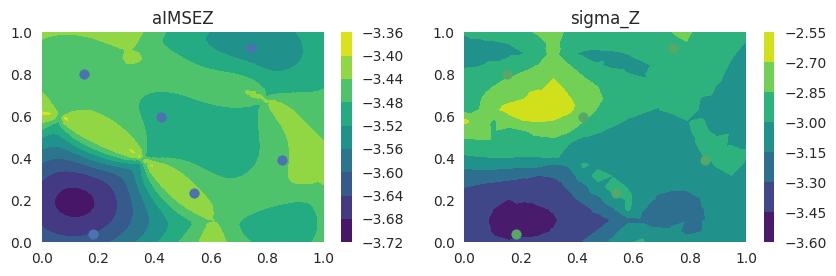

In [7]:
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8')
# plt.rc("text.latex", preamble=r"\usepackage{amsmath} \usepackage{amssymb}")
plt.rcParams.update({
    # "text.usetex": True,
    # "font.family": "serif",
    # "font.serif": ["DejaVu", "Verdana", "Computer Modern Roman"],
    # 'font.sans-serif' : ['Tahoma', 'DejaVu Sans','Lucida Grande', 'Verdana'],
    'image.cmap': u'viridis',
    'figure.figsize': [8, 8],
    'savefig.dpi': 200
})

data = np.genfromtxt("tmp/aIMSE.txt", skip_header=True, delimiter=',')
# plt.plot(data[:, -1])
plt.figure(figsize=(10, 6))
plt.subplot(2, 2, 1)
plt.tricontourf(data[:, 0], data[:, 1], np.log(data[:, 2]))
plt.colorbar()
plt.scatter(branin.gp.X_train_[:, 0], branin.gp.X_train_[:, 1])
plt.title(r'aIMSEZ')

plt.subplot(2, 2, 2)
plt.contourf(xmg, ymg, branin.gp.predict(XY, return_std=True)[1].reshape(50, 50))
plt.scatter(branin.gp.X_train_[:, 0], branin.gp.X_train_[:, 1])
plt.title(r'sigma_Z')

data_aIMSE = np.genfromtxt("tmp/aIMSE_Delta_1.txt", skip_header=True, delimiter=',')
plt.tricontourf(data_aIMSE[:, 0], data_aIMSE[:, 1], np.log(data_aIMSE[:, 2]))
plt.colorbar()
plt.scatter(branin.gp.X_train_[:, 0], branin.gp.X_train_[:, 1])
# plt.scatter(data[:, 0], data[:, 1])

In [11]:
plt.close()

In [7]:
import scipy

def augmented_design(arg, X, scenarios, function_, args, verbose=False):
    if isinstance(arg, tuple):
        m, s = arg
    else:
        m, s = arg.predict(X, return_std=True)
    if scenarios is None:
        scenarios = lambda mp, sp: scipy.stats.norm.ppf(
            np.linspace(0.05, 0.95, 5, endpoint=True), loc=mp, scale=sp
        )
    augmented_meas = np.empty(len(m))
    for j, (m_, s_) in enumerate(zip(m, s)):
        augmented_sc = np.empty(5)
        for i, zi in enumerate(scenarios(m_, s_)):
            aug_gp = arg.augmented_GP(X[j], zi)
            augmented_sc[i] = function_(aug_gp, **args).mean()
        augmented_meas[j] = augmented_sc.mean()
    return augmented_meas


In [8]:

import multiprocessing
def save_at_each_iteration_parallel(filename, header=None, nworkers=4):
    def decorator(function):
        pool = multiprocessing.Pool(processes=nworkers)
        def pooled_func(XY, *args, **kwargs):
            elt_func = lambda xy: function(xy.reshape(-1, 2), *args, **kwargs)
            result = pool.map(elt_func, XY)
            return result
        return pooled_func

    return decorator

In [74]:
import functools, time

def pooled_func(XY, *args, **kwargs):
    elt_func = lambda xy: function(xy.reshape(-1, 2), *args, **kwargs)
    result = multiprocessing.pool.map(elt_func, XY)
    return result


def parallel(func=None, **options):
    if func is None:
        return functools.partial(parallel, **options)

    def wrapper(iterable, **kwargs):
        processes = options["processes"]

        with multiprocessing.Pool(processes) as pool:
            result = pool.map(func, iterable)

        return result

    return wrapper


def test(i):
    time.sleep(1)
    print(f"{i}: {i * i}")

test_parallel = parallel(test, processes=6)



In [68]:
def function_pool(XY):
    return augmented_IMSE_Delta(
        branin,
        XY,
        scenarios=None,
        integration_points=integration_points,
        alpha=1.0,
    )

In [75]:
func_par = parallel(pooled_func, processes=4)

In [76]:
func_par(XYs)

AttributeError: module 'multiprocessing.pool' has no attribute 'map'